In [884]:
from src import data_loader as dl
from src.data_loader import PVDataLoader
from src.models import ExactGPModel
from src.variational_dist import VariationalBase
from src.beta_likelihood import BetaLikelihood
from src.models import BetaGP, GaussianGP, ExactGPModel
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from src.plotting import plot_grid, plot_gp, plot_train_test_split, plot_acf_pacf

## Preprocessing Steps

In [22]:
df_location = dl.load_data('pv_data', 'system_location.csv')
df_pv = dl.load_data('pv_data', 'pv.netcdf')

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 19 m : 13 sec



In [3]:
# Set the parameters for data preprocessing
THRESHOLD = 0.05
DAY_MIN = 8
DAY_MAX = 16

In [25]:
df_location = dl.set_index(df_location)

# align pv systems to locations from metadata and the pv data
df_location, df_pv = dl.align_pv_systems(df_location=df_location, 
                                         df_pv=df_pv)

# scale by capacity
df_pv = dl.scale_by_capacity(df_pv, df_location)

# drop systems producing over night
df_pv = dl.drop_night_production(df_pv=df_pv,
                                 threshold=THRESHOLD)

# get daily production from 8am to 4pm
df_pv = dl.daily_production(df_pv=df_pv,
                            day_min=DAY_MIN,
                            day_max=DAY_MAX)

# remove systems with zero production for more than 5 percent of the time
df_pv = dl.remove_zero_production(df_pv=df_pv,
                                  thresh=THRESHOLD)


Dropping 54 systems producing over night


In [26]:
datetime = df_pv.index
df_pv = df_pv.reset_index(drop=True)

df_location, df_pv = dl.align_pv_systems(df_pv=df_pv,
                                         df_location=df_location)
df_pv['datetime'] = datetime

In [27]:
dl.save_csv(df_pv, 'pv_data', 'pv_data_clean.csv')
dl.save_csv(df_location, 'pv_data', 'location_data_clean.csv')

## Example of using preprocessed data

In [885]:
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 30
RADIUS = 0.75
COORDS = (55.55074, -4.3278)

In [4]:
df_pv = dl.load_data('pv_data', 'pv_data_clean.csv')
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 13 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [5]:
df_location = dl.set_index(df_location)
datetime = df_pv['datetime']

In [6]:
systems = dl.find_nearby_systems(df_location, 
                                     lat=COORDS[0],
                                     lon=COORDS[1],
                                     radius=RADIUS)

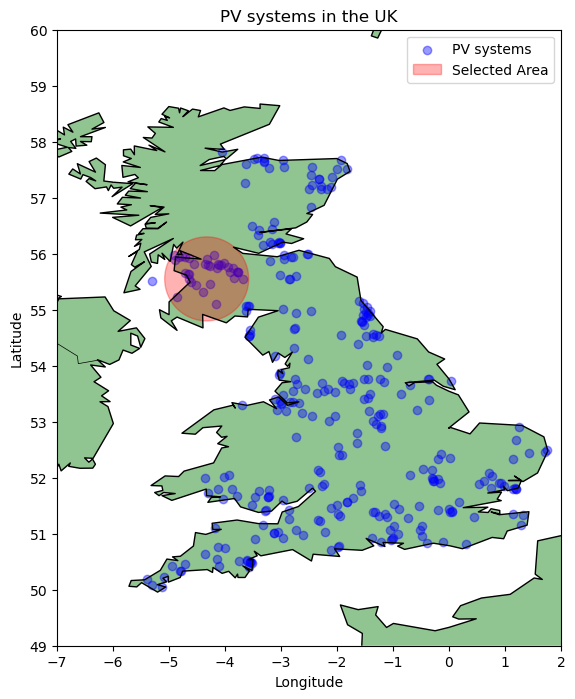

In [7]:
from src.plotting import plot_grid
plot_grid(df_location, COORDS, RADIUS)

In [596]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=10,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')



==> Loading data
==> Loaded data in: 0 m : 10 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [597]:
time, y = loader.get_time_series()

In [598]:
time_train, y_train, time_test, y_test = dl.train_test_split(time, y, n_hours=3)

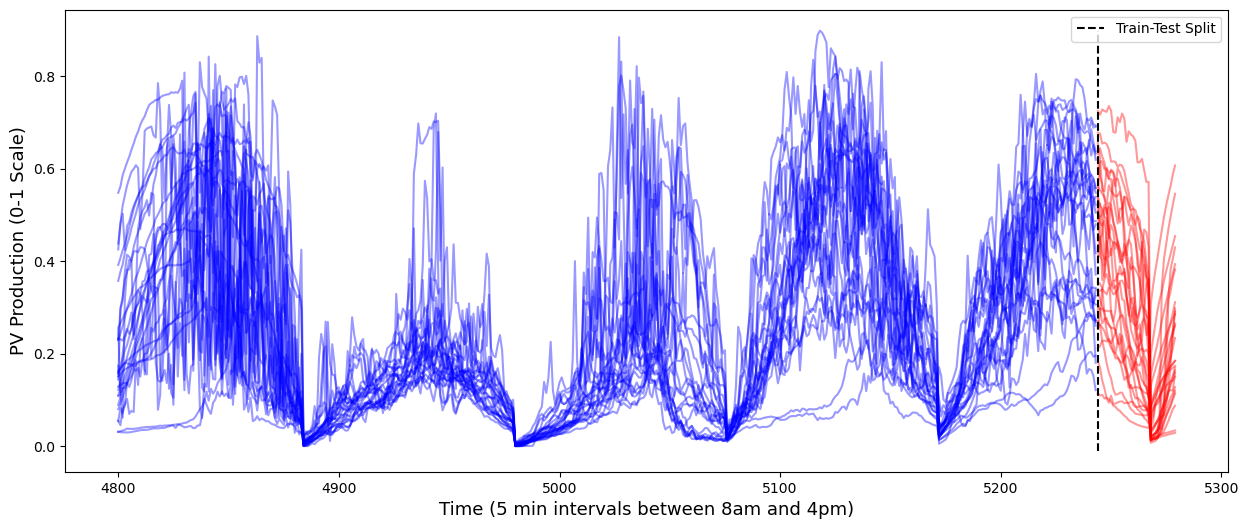

In [599]:
plot_train_test_split(time_train, time_test, y_train, y_test)

# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

In [886]:
from typing import Any, Optional
import torch
from torch import Tensor
from torch.distributions import Beta
from gpytorch.constraints import Interval, Positive
from gpytorch.priors import Prior
from gpytorch.likelihoods import _OneDimensionalLikelihood



class BetaLikelihood(_OneDimensionalLikelihood):
    """
    A Beta likelihood for regressing over percentages.

    The Beta distribution is parameterized by :math:`\alpha > 0` and :math:`\beta > 0` parameters
    which roughly correspond to the number of prior positive and negative observations.
    We instead parameterize it through a mixture :math:`m \in [0, 1]` and scale :math:`s > 0` parameter.

    .. math::
        \begin{equation*}
            \alpha = ms, \quad \beta = (1-m)s
        \end{equation*}

    The mixture parameter is the output of the GP passed through a logit function :math:`\sigma(\cdot)`.
    The scale parameter is learned.

    .. math::
        p(y \mid f) = \text{Beta} \left( \sigma(f) s , (1 - \sigma(f)) s\right)

    Args:
        batch_shape (torch.Size, optional): The batch shape of the likelihood. Default: torch.Size([])
        scale_prior (Prior, optional): Prior over the scale parameter (default: None).
        scale_constraint (Interval, optional): Constraint to place over the scale parameter (default: Interval(0, 1)).
    """

    def __init__(
        self,
        batch_shape: torch.Size = torch.Size([]),
        scale_prior: Optional[Prior] = None,
        scale_constraint: Optional[Interval] = None,
    ) -> None:
        super().__init__()

        if scale_constraint is None:
            scale_constraint = Positive()

        self.raw_scale = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        if scale_prior is not None:
            self.register_prior("scale_prior", scale_prior, lambda m: m.scale, lambda m, v: m._set_scale(v))

        self.register_constraint("raw_scale", scale_constraint)

    @property
    def scale(self) -> Tensor:
        return self.raw_scale_constraint.transform(self.raw_scale)

    @scale.setter
    def scale(self, value: Tensor) -> None:
        self._set_scale(value)

    def _set_scale(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_scale)
        self.initialize(raw_scale=self.raw_scale_constraint.inverse_transform(value))    

    def forward(self, function_samples: Tensor, *args: Any, **kwargs: Any) -> Beta:
        
        # Map function samples to the range [0, 1] 
        # TODO explore other methods than sigmoid
        mapped_samples = torch.tanh(function_samples) / 2 + 0.5

        # probit link function
        # mapped_samples = torch.erf(function_samples / 2 ** 0.5) 

        self.alpha = self.scale * mapped_samples 
        self.beta = self.scale - self.alpha

        # return Beta(concentration1=self.alpha, concentration0=self.beta)
        
        return Beta(concentration1=self.alpha.exp(), concentration0=self.beta.exp())



In [887]:
time, y = loader.get_time_series()
idx = 6
y_in = y[:, idx]

x_train, y_train, x_test, y_test = dl.train_test_split(time, y_in, n_hours=3)

idx = np.random.choice(x_train.shape[0], 350, replace=False)
x_inducing = x_train[idx]
y_inducing = y_train[idx]

In [889]:
from gpytorch.kernels import MaternKernel, ScaleKernel, AdditiveKernel, ProductKernel, PeriodicKernel
from gpytorch.means import ConstantMean
# TODO add a prior to the lengthscale in matern, and the period in periodic
lmbda = 10
matern = MaternKernel(nu=3/2, 
                      ard_num_dims=1)
quasi_periodic = ProductKernel(MaternKernel(nu=3/2), PeriodicKernel())
scaled_additive = ScaleKernel(AdditiveKernel(matern, quasi_periodic))

In [891]:
types = ['stochastic']
names = ['cholesky', 'mean_field']
num_inducing_points = [x_inducing.size(0), x_train.size(0)]
days = np.arange(0, 200, 10)
models = ['BetaSVI', 'GaussianSVI', 'GaussianExact']


In [892]:
from gpytorch.likelihoods import GaussianLikelihood
from src.models import BetaGP, GaussianGP, ExactGPModel
from src.metrics import rmse, mae
import time

def run_gp_experiments(inputs : dict,
                   num_inducing_points : list,
                   days : list = np.arange(0, 200, 10),
                   models : list = ['BetaSVI', 'GaussianSVI', 'GaussianExact'],
                   n_svi : int = 10,
                   names : list = ['cholesky', 'mean_field'],
                   hyper_params : dict = {'lr': 0.1, 
                                          'n_iter': 100, 
                                          'optim' : torch.optim.Adam, 
                                          'device': torch.device('cpu')},
                   metrics : list = [rmse, mae]
                   ):
    """
    Run an experiment over a grid of configurations &
    models and save the results to a txt file.
    The SVI models are trained several times to account
    for the stochasticity of the optimization similar
    to that of neural networks as the optimization is
    non-convex.

    Args:
        inputs (dict): dictionary of inputs to the GP model
        num_inducing_points (list): list of number of inducing points
        days (list, optional): list of number of days to train on. Defaults to np.arange(0, 200, 10).
        models (list, optional): list of models to train. Defaults to ['BetaSVI', 'GaussianSVI', 'GaussianExact'].
        n_svi (int, optional): number of times to train the SVI models. Defaults to 5.
        names (list, optional): list of names of the variational distributions. Defaults to ['cholesky', 'mean_field'].
        hyper_params (dict, optional): dictionary of hyperparameters for the optimizer. Defaults to {'lr': 0.1, 'n_iter': 100, 'optim' : torch.optim.Adam, 'device': torch.device('cpu')}.
        metrics (list, optional): list of metrics to evaluate the model. Defaults to [rmse, mae].
    """
    
    config = {'type': 'stochastic',
              'mean_init_std': 1e-2}
    
    results = {'GaussianSVI': None,
                'BetaSVI': None,
                'GaussianExact': None
                }
    
    time_total_start = time.time()

    for n in names:
        for n_ind in num_inducing_points:
            for d in days:
                for model in models:
                    # add keys and values to config
                    config['name'] = n
                    config['num_inducing_points'] = n_ind
                    config['n_days'] = d
                    config['model'] = model
                    inputs['config'] = config

                    # run experiment
                    if model == 'BetaSVI':
                        model = BetaGP(**inputs)
                    elif model == 'GaussianSVI':
                        model = GaussianGP(**inputs)
                    elif model == 'GaussianExact':
                        inputs['likelihood'] = GaussianLikelihood() 
                        model = ExactGPModel(**inputs)
                        # delete likelihood from inputs
                        del inputs['likelihood']
                    
                    # train model and predict
                    # TODO random initialization of hyperparameters for each run
                    rmse_list = []
                    mae_list = []
                    
                    print(f'Running experiment with {model} for {n_svi} iterations')
                    time_start_fit = time.time()
                    for _ in range(n_svi):
                        model.fit(**hyper_params)
                        print(f'Model: {model}')
                        preds = model.predict(inputs['x_test'], device=hyper_params['device'])
                        
                        if isinstance(model.likelihood, gpytorch.likelihoods.GaussianLikelihood):
                            preds = preds.mean
                        else:
                            preds = preds.mean.mean(axis=0)
                        
                        rmse_list.append(rmse(inputs['y_test'], preds))
                        mae_list.append(mae(inputs['y_test'], preds))
                    
                        # TODO add uncertainty metrics 
                    time_end_fit = time.time()
                    print(f'Finished training in {time_end_fit - time_start_fit:.2f} seconds')
                    results[model] = {'rmse' : (np.mean(rmse_list), np.std(rmse_list)),
                                      'mae' : (np.mean(mae_list), np.std(mae_list))}
                    
        

In [872]:
config = {
    'type': 'stochastic',
    'name': 'mean_field',
    'num_inducing_points': x_inducing.size(0),
    'mean_init_std': 1e-4,
}

model_beta = BetaGP(X=x_inducing, 
               y=y_inducing,
               mean_module=ConstantMean(),
               covar_module=ScaleKernel(scaled_additive),
               config=config,
               jitter=1e-4
                )
model_beta.fit(n_iter=100, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'))
                     

Iter 10/100 - Loss: -0.292
Iter 20/100 - Loss: -0.486
Iter 30/100 - Loss: -0.625
Iter 40/100 - Loss: -0.792
Iter 50/100 - Loss: -0.952
Iter 60/100 - Loss: -1.081
Iter 70/100 - Loss: -1.111
Iter 80/100 - Loss: -1.151
Iter 90/100 - Loss: -1.178
Iter 100/100 - Loss: -1.189


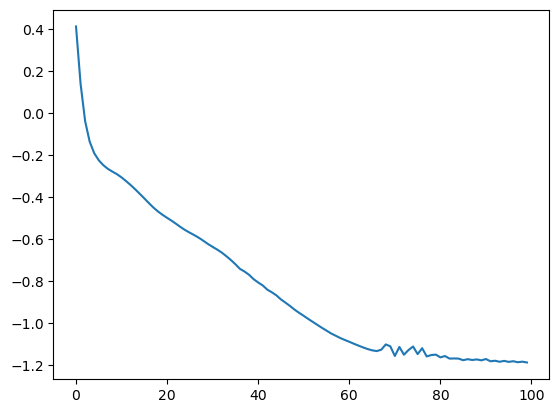

In [873]:
plt.plot(model_beta.losses)

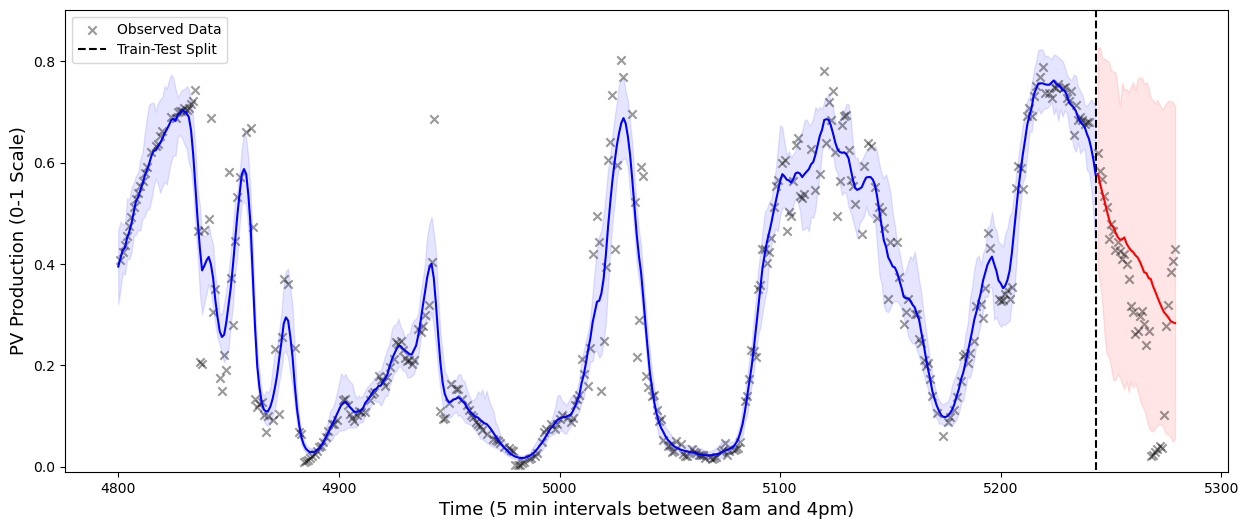

In [875]:
plot_gp(model_beta, x_train, x_test, y_train, y_test, x_inducing, y_inducing)

In [861]:
print('alpha range: ', model_beta.likelihood.alpha.min().item(), model_beta.likelihood.alpha.max().item())
print('beta range: ', model_beta.likelihood.beta.min().item(), model_beta.likelihood.beta.max().item())

alpha range:  1.1924431324005127 2.829235076904297
beta range:  1.7726211547851562 3.4094130992889404


In [879]:
config = {
    'type': 'stochastic',
    'name': 'mean_field',
    'num_inducing_points': x_inducing.size(0),
    'mean_init_std': 1e-4,
}

model_gaussian_svi = GaussianGP(X=x_inducing, 
                   y=y_inducing,
                   mean_module=ConstantMean(),
                   covar_module=ScaleKernel(scaled_additive),
                   config=config,
                   jitter=1e-3
                   )
model_gaussian_svi.fit(n_iter=100, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'))

Iter 10/100 - Loss: 0.466
Iter 20/100 - Loss: 0.080
Iter 30/100 - Loss: -0.317
Iter 40/100 - Loss: -0.602
Iter 50/100 - Loss: -0.696
Iter 60/100 - Loss: -0.696
Iter 70/100 - Loss: -0.714
Iter 80/100 - Loss: -0.717
Iter 90/100 - Loss: -0.719
Iter 100/100 - Loss: -0.720


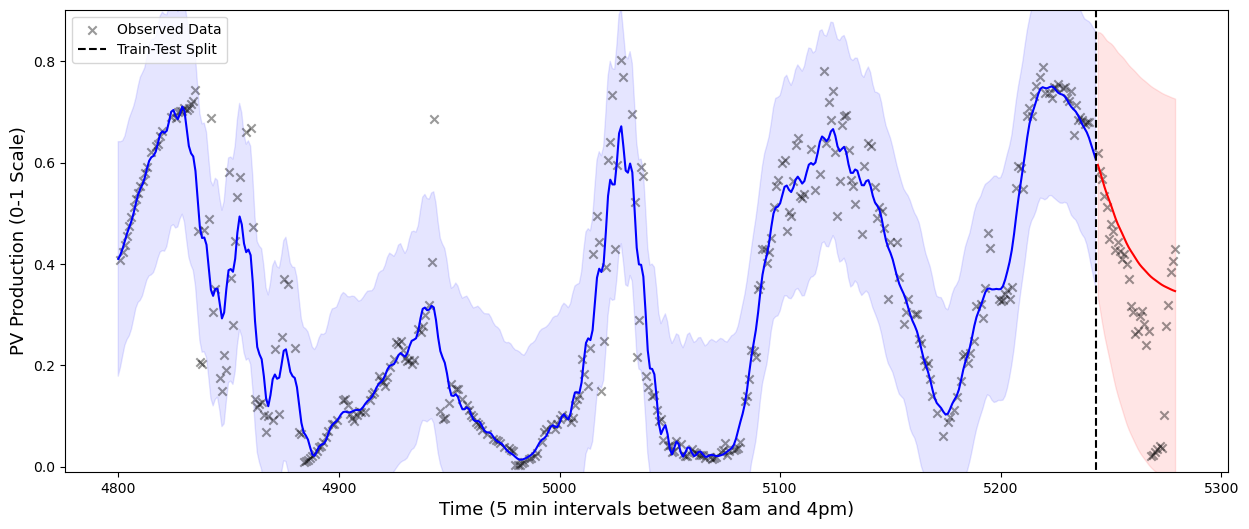

In [880]:
plot_gp(model_gaussian_svi, x_train, x_test, y_train, y_test,  x_inducing, y_inducing)

In [881]:
model_exact = ExactGPModel(X=x_train,
                           y=y_train,
                           likelihood=GaussianLikelihood(),
                           mean_module=ConstantMean(),
                           covar_module=ScaleKernel(scaled_additive))
model_exact.fit(n_iter=100, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'))


Iter 10/100 - Loss: 0.450
Iter 20/100 - Loss: 0.031
Iter 30/100 - Loss: -0.385
Iter 40/100 - Loss: -0.733
Iter 50/100 - Loss: -0.944
Iter 60/100 - Loss: -1.016
Iter 70/100 - Loss: -1.016
Iter 80/100 - Loss: -1.019
Iter 90/100 - Loss: -1.025
Iter 100/100 - Loss: -1.028


/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


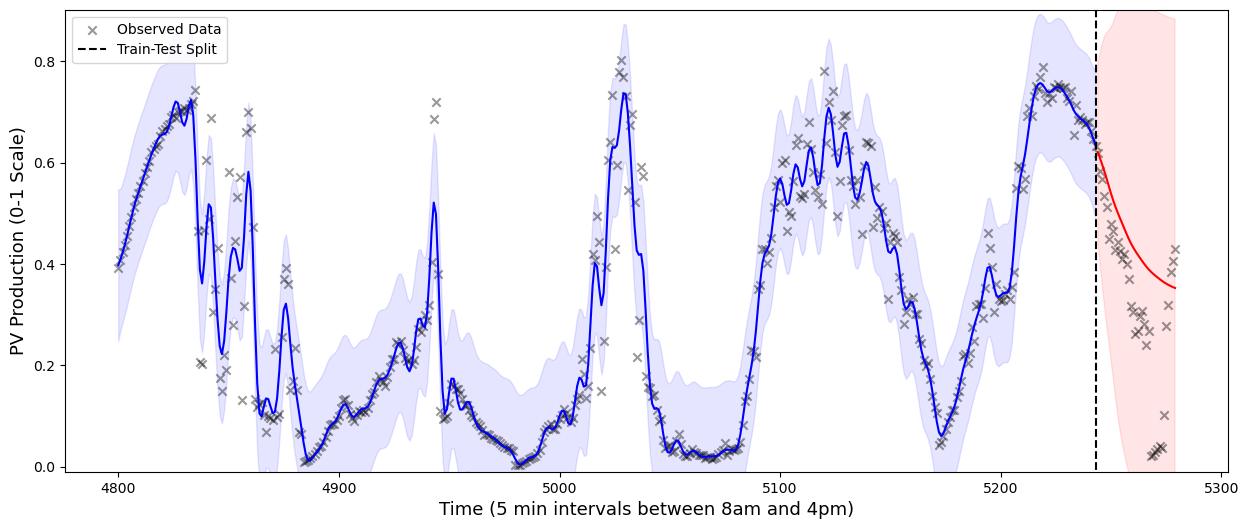

In [882]:
plot_gp(model_exact, x_train, x_test, y_train, y_test)

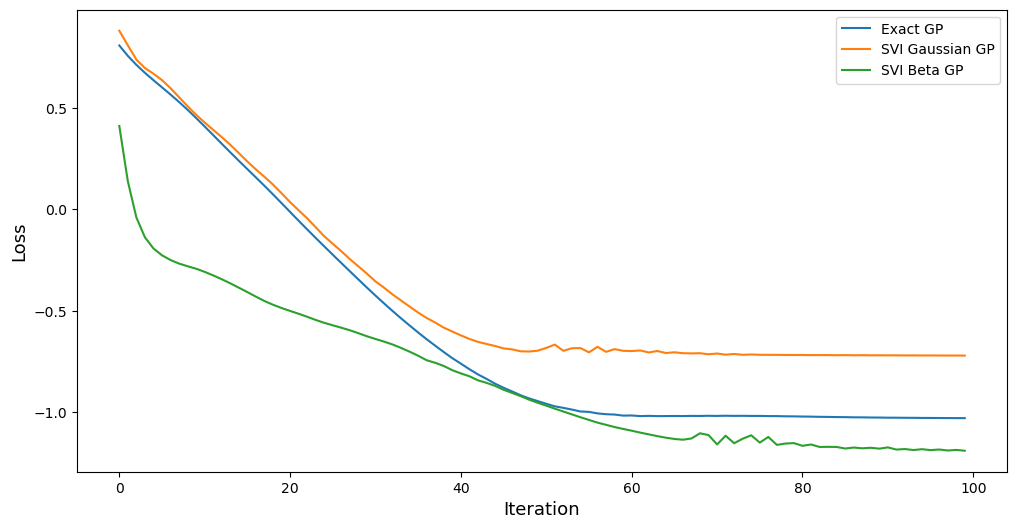

In [883]:
plt.figure(figsize=(12, 6))

plt.plot(model_exact.losses, label='Exact GP')
plt.plot(model_gaussian_svi.losses, label='SVI Gaussian GP')
plt.plot(model_beta.losses, label='SVI Beta GP')

plt.xlabel('Iteration', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend()

# Baselines

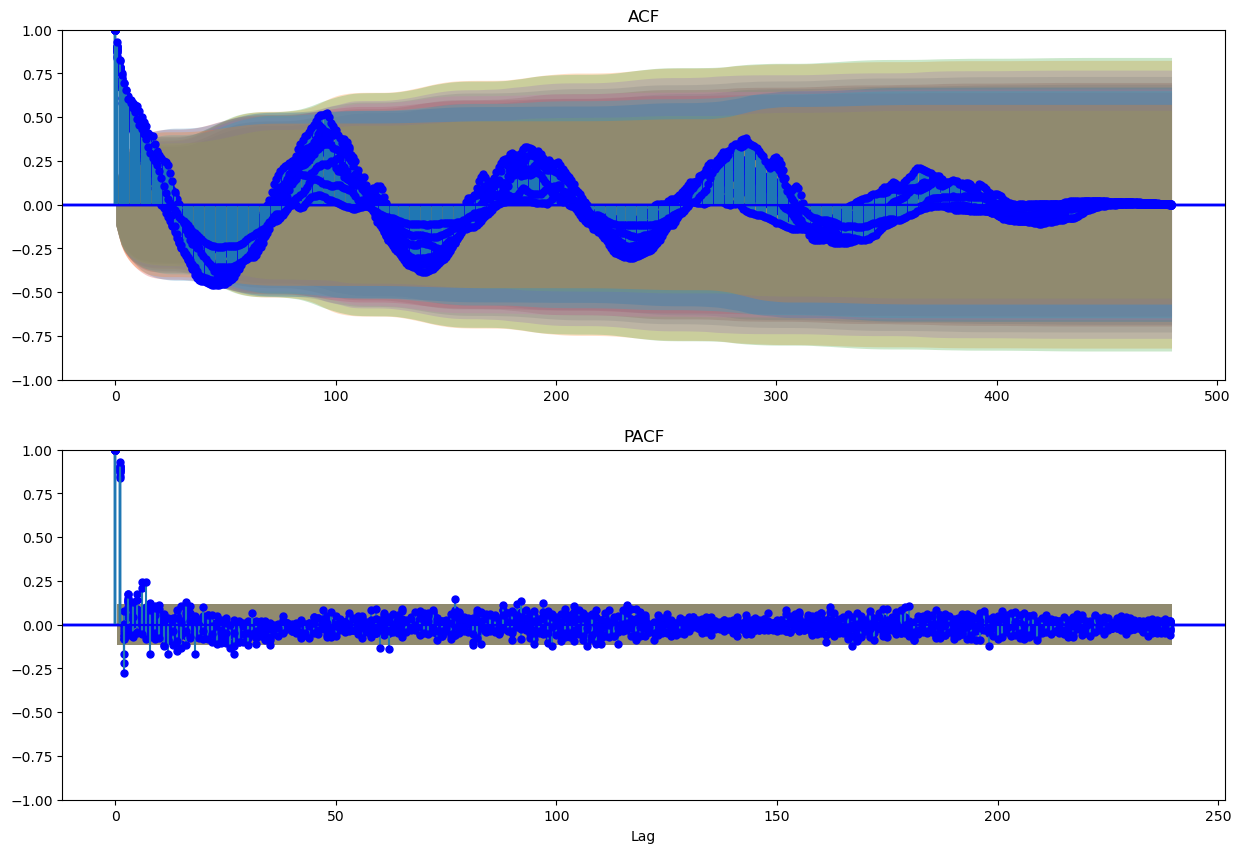

In [66]:
# create function for plotting acf and pacf for all systems in a grid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(y):
    """
    Plot the acf and pacf for all systems in a grid
    """
    _, ax = plt.subplots(2, 1, figsize=(15, 10))
    for i in range(y.shape[1]):
        plot_acf(y[:, i], ax=ax[0], alpha=0.01, lags=len(y) - 1, title='ACF', color='b')
        plot_pacf(y[:, i], ax=ax[1], alpha=0.01, lags=len(y) // 2 - 1, title='PACF', color='b', method='ywm')
    
    plt.xlabel('Lag')
    
    plt.show()

plot_acf_pacf(y)
    


# TODO!! Decide how to use ACF / PACF on selecting amount of data to GP Model & Time Series Models

In [419]:
from statsmodels.tsa.api import AutoReg, ARIMA, SARIMAX, ExponentialSmoothing, MarkovAutoregression


class BaseLineModels:
    """ 
    Global class for time series forecasting models
    
    Args:
        time_train (torch.Tensor): training time
        y_train (torch.Tensor): training data
        time_test (torch.Tensor): test time
        y_test (torch.Tensor): test data
    """
    def __init__(self, time_train, y_train, time_test, y_test):
        self.time_train = time_train
        self.y_train = y_train
        self.time_test = time_test
        self.y_test = y_test
    
    def exponential_smoothing(self, **kwargs):
        """
        Exponential smoothing model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def arima(self, **kwargs):
        """
        ARIMA model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def sarima(self, **kwargs):
        """
        SARIMA model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def sarimax(self, **kwargs):
        """
        SARIMAX model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def var(self, **kwargs):
        """
        VAR model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def varmax(self, **kwargs):
        """
        VARMAX model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    

In [425]:
class ExponentialModels(ExponentialSmoothing):
    """ 
    Global class for exponential smoothing models

    Args:
        time_train (torch.Tensor): training time
        y_train (torch.Tensor): training data
        time_test (torch.Tensor): test time
        y_test (torch.Tensor): test data
    """
    def __init__(self, y_train, y_test, trend):
        super(ExponentialModels, self).__init__(y_train, trend=trend)
        self.y_train = y_train
        self.y_test = y_test
    
    def single_exponential_smoothing(self, alpha : float = 0.2):
        """
        Single exponential smoothing model
        
        Args:
            alpha (float): smoothing parameter
        """
        self.fit(smoothing_level=alpha, optimized=False)
        return self.forecast(len(self.y_test))
    
    def double_exponential_smoothing(self, alpha : float = 0.2, beta : float = 0.2, trend : str = 'add'):
        """
        Double exponential smoothing model
        
        Args:
            alpha (float): smoothing parameter for level
            beta (float): smoothing parameter for trend
            trend (str): type of trend to use
        """
        assert trend in ['add', 'mul'], 'trend must be either add or mul'

        self.fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False, use_brute=True)
        return self.forecast(len(self.y_test))
    


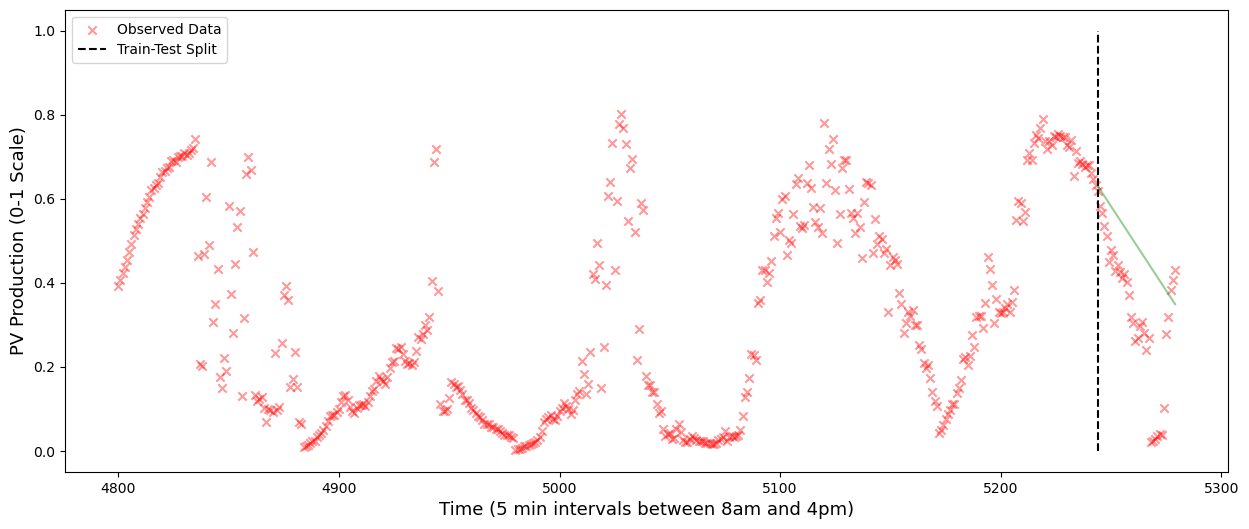

In [456]:
test = y_train[:, 6].numpy().shape

exp_model = ExponentialSmoothing(endog=y_train[:, 6].numpy(),
                                 trend='add',
                                 )
exp_model.fit(smoothing_level=0.2, smoothing_trend=0.2, optimized=False, use_brute=True)
y_pred = exp_model.predict(params=exp_model.params, start=len(y_train), end=len(y_test) + len(y_train) - 1)

plt.figure(figsize=(15, 6))
plt.scatter(time_train, y_train[:, 6], color='r', alpha=0.4, marker = 'x', label='Observed Data')
plt.scatter(time_test, y_test[:, 6], color='r', alpha=0.4, marker = 'x')

plt.vlines(x=len(y_train[:,0]) + time_train.min(), ymin=0, ymax=1, color='black', linestyle='--', label='Train-Test Split')
plt.plot(time_test, y_pred, color='g', alpha=0.4)

plt.xlabel('Time (5 min intervals between 8am and 4pm)', fontsize=13)
plt.ylabel('PV Production (0-1 Scale)', fontsize=13)

plt.legend(loc='upper left')

In [427]:
model = ExponentialModels(y_train=y_train[:, idx].numpy(),
                          y_test=y_test[:, idx].numpy(),
                          trend ='add')

preds = model.single_exponential_smoothing(alpha=0.2)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'